In [9]:
using Pkg
Pkg.activate(".")

  Activating project at `/data/gpfs/projects/punim0638/stephenz/locaTE.jl/examples/HSPC`


In [10]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra
using Plots
using StatsBase
using CUDA
using Random
using NNlib

In [11]:
OUT_DIR = "locaTE_output/"
DATA_DIR = "data/"
X = npzread(joinpath(DATA_DIR, "X.npy"))
TE = npzread(joinpath(OUT_DIR, "TE.npy"));
L = sparse(npzread(joinpath(OUT_DIR, "L.npy")));
qnorm(x, q) = x ./ quantile(vec(x), q);

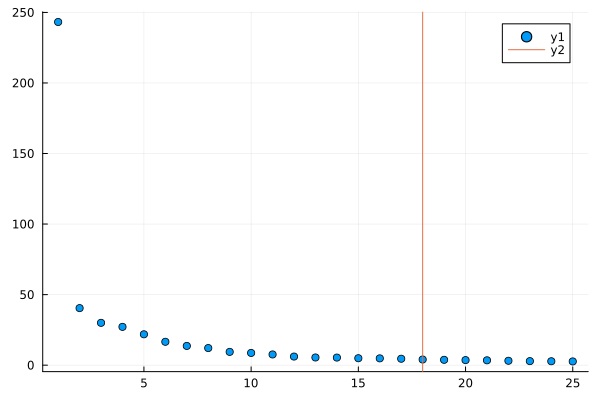

In [12]:
_, s, _ = svd(TE); s.^=2
scatter(s[1:25])
svd_rank=findall((cumsum(s) .> 0.75*sum(s)))[1]
vline!([svd_rank, ])

In [13]:
Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(TE, 0.9))),
                     [I(size(TE, 1)), I(size(TE, 2))], 1e-3*I + L,
                     cu(repeat(zeros(size(TE, 2)), 1, size(TE, 1))'), 
                     svd_rank; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 5_000, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:03:29


In [14]:
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
V .*= maximum(U; dims = 1)
U ./= maximum(U; dims = 1);
# 
A = reshape(maximum(V'; dims = 1), size(X, 2), size(X, 2))
for i = 1:size(V, 2)
    x = reshape(V[:, i], size(X, 2), size(X, 2))
    V[:, i] .= vec(locaTE.cdf_norm(x, A .+ 1e-9))
end

npzwrite(joinpath(OUT_DIR, "U.npy"), U)
npzwrite(joinpath(OUT_DIR, "V.npy"), V)

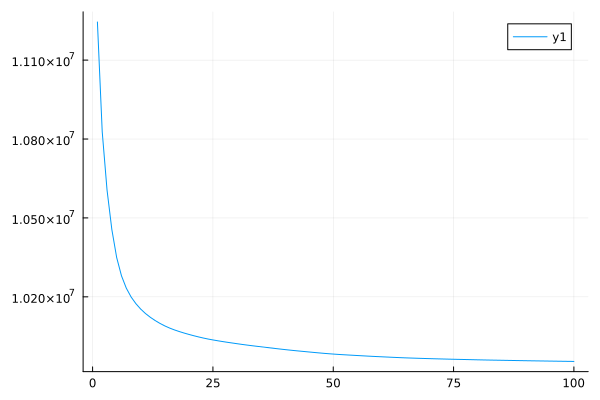

In [15]:
plot(trace)